In [1]:

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPool2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.callbacks import Callback
from tensorflow.keras.callbacks import LearningRateScheduler,EarlyStopping, ModelCheckpoint

import os
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.2.0


In [ ]:
# !cat /proc/cpuinfo

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
DATA_PATH= 'drive/My Drive/MasterNU/RevisionBSLDigits/TrainTest/'

In [ ]:
CLASS_NUM = 10
WIDTH = 64
HEIGHT = 64
CHANNEL = 3
EPOCHS = 500
BATCH_SIZE = 128

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   rotation_range=15,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    DATA_PATH+'train/',
    target_size = (HEIGHT, WIDTH),
    batch_size = BATCH_SIZE,
    class_mode = 'sparse',
        shuffle = True,
)

test_generator = test_datagen.flow_from_directory(
    DATA_PATH+'test/',
    target_size = (HEIGHT, WIDTH),
    batch_size = BATCH_SIZE,
    class_mode='sparse',
    shuffle=False,
)

Found 8000 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.


## Visualizing Training Images

In [ ]:
#next function returns two two output x_train and y_train
sample_training_images, _ = next(train_generator)

In [ ]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(10,10))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

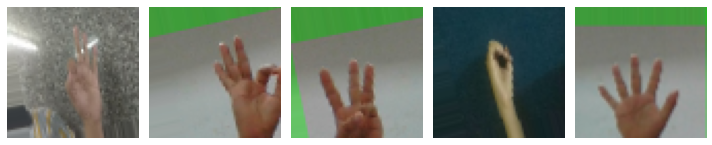

In [ ]:
plotImages(sample_training_images[:5])

In [ ]:
# VGG16 Style Architecture
model = tf.keras.Sequential()
model.add(Conv2D(32, (5, 5), input_shape=(HEIGHT, WIDTH, CHANNEL), activation='relu', padding='same'))
model.add(Conv2D(32, (5, 5), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2), strides=2))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2), strides=2))
model.add(Dropout(0.2))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2), strides=2))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(CLASS_NUM, activation="softmax"))

In [ ]:
model.summary()

In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
filepath="weights-improvement-{epoch:02d}-{val_accuracy:.2f}.h5"

# Call back
mc = ModelCheckpoint(filepath, monitor ='loss', verbose = 1, save_best_only=True, mode = 'max')
es = EarlyStopping(monitor='loss', patience=3, verbose=1, mode='min',restore_best_weights=True)
# sheduler_lr = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x)
callbacks = [mc,es]

# Steps
SPE = len(train_generator)
VS = len(test_generator)

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch = SPE,
    validation_data = test_generator,
    validation_steps = VS,
    epochs = EPOCHS,
    callbacks = callbacks
)

Epoch 1/500
125/125 [==============================] - ETA: 0s - loss: 0.2827 - accuracy: 0.9031
Epoch 00001: loss improved from -inf to 0.28271, saving model to weights-improvement-01-0.95.h5
125/125 [==============================] - 39s 312ms/step - loss: 0.2827 - accuracy: 0.9031 - val_loss: 0.1558 - val_accuracy: 0.9535
Epoch 2/500
125/125 [==============================] - ETA: 0s - loss: 0.2785 - accuracy: 0.9066
Epoch 00002: loss did not improve from 0.28271
125/125 [==============================] - 40s 324ms/step - loss: 0.2785 - accuracy: 0.9066 - val_loss: 0.1497 - val_accuracy: 0.9525
Epoch 3/500
125/125 [==============================] - ETA: 0s - loss: 0.2767 - accuracy: 0.9069
Epoch 00003: loss did not improve from 0.28271
125/125 [==============================] - 40s 318ms/step - loss: 0.2767 - accuracy: 0.9069 - val_loss: 0.1560 - val_accuracy: 0.9525
Epoch 4/500
125/125 [==============================] - ETA: 0s - loss: 0.2695 - accuracy: 0.9074
Epoch 00004: loss di

In [ ]:
# Test Accuracy
scores = model.evaluate(test_generator, steps=len(test_generator), verbose=1)
print("Test Accuracy: %.2f%%" % (scores[1]*100))

In [ ]:
# Train Accuracy
scores = model.evaluate(train_generator, steps=len(train_generator), verbose=1)
print("Train Accuracy: %.2f%%" % (scores[1]*100))

In [ ]:
len(train_generator)

250

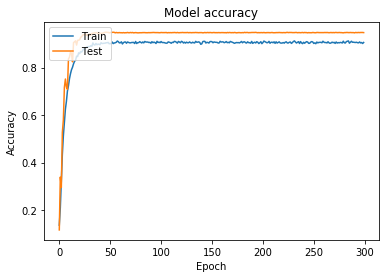

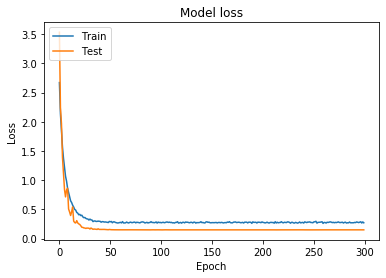

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

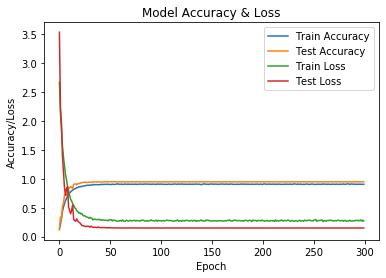

In [ ]:

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Accuracy & Loss')
plt.ylabel('Accuracy/Loss')
plt.xlabel('Epoch')
plt.legend(['Train Accuracy', 'Test Accuracy', 'Train Loss', 'Test Loss'])
plt.show()

# Plot training & validation loss values
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('Model loss')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.legend(['Train Accuracy', 'Test Accuracy', 'Train Loss', 'Test Loss'], loc='upper left')
# plt.show()
#loc='upper left'

In [ ]:
classes = test_generator.class_indices
print(classes)

{'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9}


## Confusion Matrix for Testing

In [ ]:
#Confution Matrix and Classification Report
from sklearn.metrics import classification_report, confusion_matrix
Y_pred = model.predict_generator(test_generator, len(test_generator))
y_pred = np.argmax(Y_pred, axis=1)
# print(y_pred)
print('Confusion Matrix')
print(confusion_matrix(test_generator.classes, y_pred))
# print(val_generator.classes)
print('Classification Report')
target_names = ['Zero', 'One', 'Two', 'Three', 'Four', 'Five','Six', 'Seven', 'Eight', 'Nine']
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

Confusion Matrix
[[198   2   0   0   0   0   0   0   0   0]
 [  0 189   7   0   0   0   1   1   1   1]
 [  0   0 191   1   0   0   6   2   0   0]
 [  0   1   0 191   0   1   2   2   0   3]
 [  0   0   0   0 190   2   4   1   0   3]
 [  0   1   0   1   1 195   1   0   0   1]
 [  0   0   2   0   4   0 189   5   0   0]
 [  1   0   4   2   0   0   6 178   6   3]
 [  0   3   1   2   2   0   1   6 183   2]
 [  0   0   0   1   3   1   3   0   1 191]]
Classification Report
              precision    recall  f1-score   support

        Zero       0.99      0.99      0.99       200
         One       0.96      0.94      0.95       200
         Two       0.93      0.95      0.94       200
       Three       0.96      0.95      0.96       200
        Four       0.95      0.95      0.95       200
        Five       0.98      0.97      0.98       200
         Six       0.89      0.94      0.92       200
       Seven       0.91      0.89      0.90       200
       Eight       0.96      0.92      0.94

Text(0.5, 1, 'Confusion Matrix')

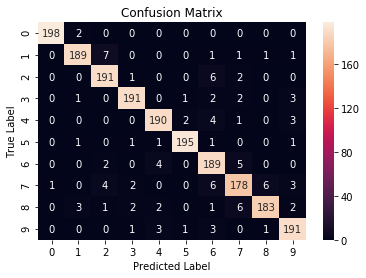

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.metrics import confusion_matrix
Y_pred = model.predict_generator(test_generator, len(test_generator))
matrix = confusion_matrix(test_generator.classes, y_pred)
sns.heatmap(matrix,annot=True,cbar=True, fmt='d')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')

Text(0.5, 1, 'Confusion Matrix')

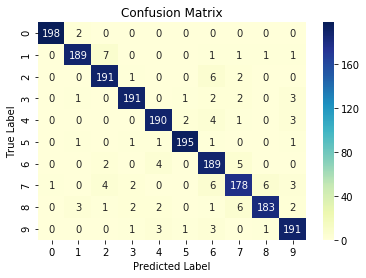

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.metrics import confusion_matrix
Y_pred = model.predict_generator(test_generator, len(test_generator))
matrix = confusion_matrix(test_generator.classes, y_pred)
sns.heatmap(matrix,annot=True,cbar=True, cmap="YlGnBu", fmt='d')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')